# Numerical Linear Regression

## Steps

1. Gradient descent with one variable
2. Newton method with one variable
3. Gradient descent with two (and more) variables
4.  Newton method with two (and more) variables

In [435]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits import mplot3d

In [436]:
rcParams["figure.facecolor"] = "white"

## Gradient descent with one variable 

Let us start a simple linear model $Y = aX$ with one feature $X$ and one response $Y$, a slope of $a$ that is to be learned assuming an intercept $b=0$.

We generate data for $Y=2X, X\in [1,10]$ with a random error that is normally distributed proportional to $\mathcal{N}(0,10)$. 

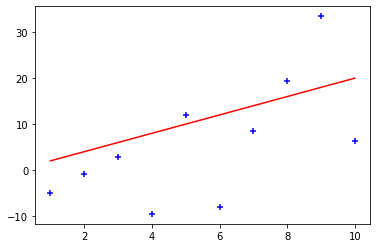

In [437]:
np.random.seed(1337)
N = 10
a0 = 2
X = np.arange(1,N+1)
Y = a0 * X + np.random.normal(0,10,size=N)
plt.scatter(X,Y,marker = "+",color = "blue")
plt.plot(X,a0*X, color = "red")
plt.show()

We learn $\hat a$ from the data and expect it to be $\approx 2$. Therefore, we minimize the residual sum of squares as our loss function, i.e., $\hat a = \min \arg RSS(a)$ where $RSS(a) =\sum_{i=1}^{n}(y_i - a x_i)^2$.  

For the sake of demonstrating the numerical approach, we deliberately ignore that an analytic solution exists. 

Let's define and plot $RSS$ as a function of $a$. We chose the range of $a$ around the (actually unknown) minimum of $\approx 2$. 

In [438]:
def rss(a,X,Y):
    n = X.shape[0]
    err = ((Y-a*X)**2).sum()
    return err

In [439]:
def plot_rss(f,a_range):
    err_range = np.array([f(a) for a in a_range])
    plt.plot(a_range,err_range)

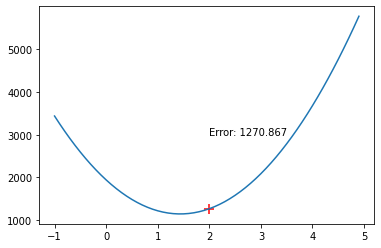

In [440]:
f = lambda a: rss(a,X,Y)
a_range = np.arange(a0-3,a0+3,0.1)
plot_rss(f,a_range)
plt.scatter(a0,f(a0),marker = "+",color = "red",s = 100)
err = f(a0)
plt.text(a0,3000,"Error: {:0.3f}".format(err))
plt.show()

The gradient of $RSS(a)$ for any $a$ is defiend as:

$$
\begin{aligned}
\nabla RSS(a) &= \frac{\partial RSS(a)}{\partial a}\\
&=\frac{\partial \sum_{i=1}^{n}(y_i- a x_i)^2}{\partial a}\\
&=\sum_{i=1}^{n}2(y_i- a x_i)(-x_i)\\
&=-2\sum_{i=1}^{n}(y_i- a x_i)x_i
\end{aligned}
$$

In [441]:
def grad_rss(a,X,Y):
    return (-2*(Y-a*X)*X).sum()

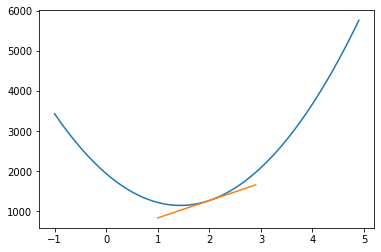

In [442]:
ff = lambda a: grad_rss(a,X,Y)
fff = lambda a:(a-a0)*ff(a0) + f(a0)
a_range = np.arange(a0-3,a0+3,0.1)
plot_rss(f,a_range)
a_range = np.arange(a0-1,a0+1,0.1)
plot_rss(fff,a_range)

We iteratively approximate $\hat a$ with gradient descent, i.e., starting with an initial guess $a_0$ and a learning rate of $\varepsilon$ we iterate over

$$
\begin{aligned}
a_{k+1} &= a_k - \varepsilon \nabla RSS(a_k) \\
&= a_k + 2 \varepsilon \sum_{i=1}^{n}(y_i- a_k x_i)x_i
\end{aligned}
$$

In [443]:
def grad_desc_rss(K,a0,learning_eps,f,ff,verbose):
    ass = np.zeros(K+1)
    ass[0] = a0
    for k in range(K):
        ass[k+1] = ass[k] - learning_eps*ff(ass[k])
        if verbose:
            plt.plot((ass[k],ass[k+1]),
                     (f(ass[k]),f(ass[k+1])),
                     linestyle = "dashed",
                     linewidth = 2,
                     color = "green",
                     zorder = 0,
                    )
            plt.scatter(ass[k+1],f(ass[k+1]),marker = "x",color = "red",s = (1+40)/K * k)
    if verbose:
        a_range = np.arange(min(ass) - 1,max(ass)+1,0.1)
        plot_rss(f,a_range)
        fff = lambda a:(a-a0)*ff(a0) + f(a0)
        a_range = np.arange(a0-1,a0+1,0.1)
        plot_rss(fff,a_range)
        fff = lambda a: (a-ass[k+1])*ff(ass[k+1])+f(ass[k+1])
        a_range = np.arange(ass[k+1]-1,ass[k+1]+1,0.1)
        plot_rss(fff,a_range)
    return ass

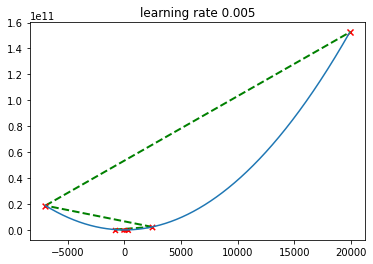

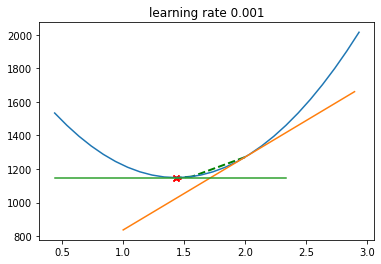

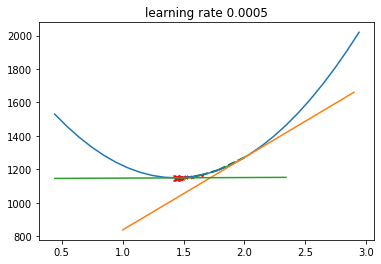

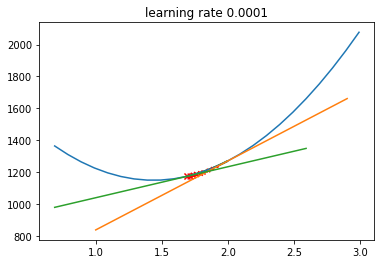

In [444]:
K = 10
for learning_eps in [0.005,0.001,0.0005,0.0001]:
    ass = grad_desc_rss(K,a0,learning_eps,f,ff,True)
    plt.title("learning rate {}".format(learning_eps))
    plt.show()

**Q**: *Try different learning rates and interpret the effect. Your answer goes here!*
<br>
<br>
**A**: What becomes obvious from our survey of different learning rates is that if the learning rate is _too large_ (e.g., 0.005) the change inflicted by the gradient update will miss the target since the the extent by which the derivative change within the region $[x_{k},x_{k+1}]$ is larger then what is fit with our linear approximation (gradient stepping). On the other hand, if the learning rate is _too small_ (e.g., 0.0001) then we avoid the risk of "overshooting" our target, but at the cost of not reaching the optimal solution with the number of specified iterations; that is, our steps are very correct but too short. Here it seems like a learning rate of 0.001 is a  good choice, it reaches the optimal solution within the specified number of iterations while not overshooting the target.<br>
<br>
Interestingly, we see that the _optimal solution_ for this data is not the actual model parameter used during data generation (our initial guess), but a slightly different value. This is because our objective function is to minimize the RSS between the observed data and our model, and with so few observations (10) and fairly large noise ($varepsilon \sim \mathcal{N}(0,10)$), the observed data will most likely not provide a fully accurate representation of the underlying generative process.

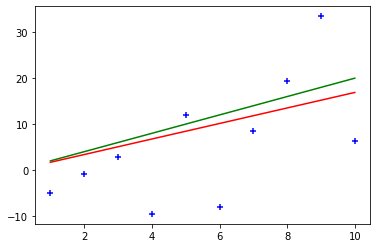

In [445]:
plt.scatter(X,Y,marker = "+",color = "blue")
plt.plot(X,a0*X,color = "green")
plt.plot(X,ass[-1]*X,color = "red")
plt.show()

## Newton method with one variable

It is obviously difficult to set the learning rate right. To help this, the Newton method adjusts the learning rate $\varepsilon$ in each step to the inverse of the second derivative $h$ of the loss function. In our case it is the inverse of the second derivative of $RSS$.

$$
\begin{aligned}
h(a) &= \frac{\partial^2 RSS(a)}{\partial a^2}\\
&=\frac{\partial (-2 \sum_{i=1}^{n}(y_i- a x_i)x_i)}{\partial a}\\
&=2\sum_{i=1}^{n}x_i^2\\
\end{aligned}
$$

We observe, that $h$ is a constant w.r.t. $a$ and, hence, it does not change during iteration in our quadratic optimization case.

In [446]:
h = 2 * (X**2).sum()
learning_eps = 1/h 

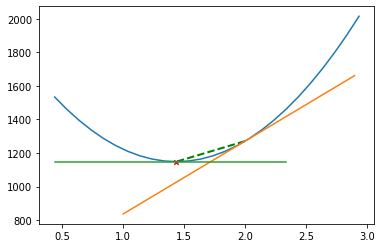

In [447]:
ass = grad_desc_rss(2,a0,learning_eps,f,ff,True)

## Gradient descent with two (and more) variables

Let us add an intercept to linear model $Y = aX +b$ still with one feature $X$ and one response $Y$, but with slope $a$ and intercept $b$ to be learned.

We generate data for $Y=2X - 3$ with a random error that is normally distributed proportional to $\mathcal{N}(0,10)$. 

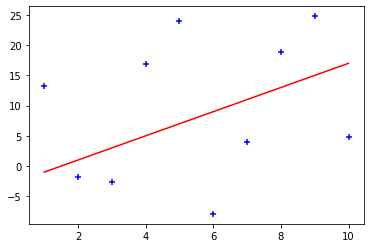

In [448]:
a0 = 2
b0 = -3
X = np.arange(1,N+1)
Y = a0*X + b0 + np.random.normal(0,10,N)
plt.scatter(X,Y,marker = "+",color = "blue")
plt.plot(X,a0*X + b0,color = "red")
plt.show()

We learn $\hat a$ and $\hat b$ from the data and expect them to be $\approx 2$ and $\approx -3$, respectively. 
Therefore, we minimize the residual sum of squares $RSS=\sum_{i=1}^{n}(y_i-\hat a x_i - \hat b)^2$.  

Let's define and 3D plot the modified $RSS$ as a function of $a$ and $b$. We chose the ranges of $a$ and $b$ around the (actually unknown) minima of $\approx 2$ and $\approx -3$, respectively. 

In [449]:
def rss2(a,b,X,Y):
    n = X.shape[0]
    err = ((Y-a*X-b)**2).sum()
    return err

In [450]:
def plot3d(f,A,B,real3d,rotation = 90):
    shape = A.shape
    Z = np.array([f(a,b) for a,b in zip(A.flatten(),B.flatten())]).reshape(shape)
    if real3d:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        sf = ax.plot_surface(A, B, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
        ax.view_init(30,rotation)
        fig.colorbar(sf)
        fig.tight_layout()
    else:
        plt.contour(A,B,Z)
        plt.colorbar()


Text(0.5, 0.92, 'Loss function (3D)')

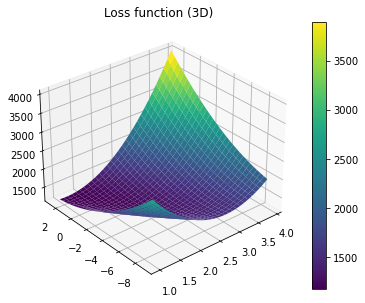

In [451]:
f = lambda a,b: rss2(a,b,X,Y)
a_vec = np.arange(a0-1,a0+2,0.1)
b_vec = np.arange(b0-6,b0+6,0.4)
A,B = np.meshgrid(a_vec,b_vec)
plot3d(f,A,B,rotation = 230,real3d = True)
plt.title("Loss function (3D)")

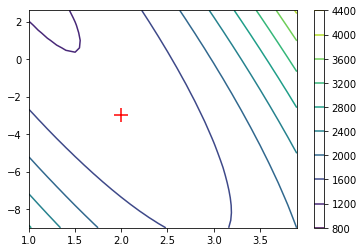

In [452]:
plot3d(f,A,B,real3d = False)
plt.scatter(a0,b0,marker ="+",c ="red",s = 200)
plt.show()

**Q**: *What can you say about the loss function space? Your answer goes here.* 
<br>
<br>
**A**: It seems like the loss function space resembles a "valley" with fairly sharp inclines on both sides of a middle passage/plateau. This means that gradient descent will fast take us to a _near optimal_ solution (in the plateau), but to find the optimal solution then will require more care as we would be positioned in a near flat-region. 

The gradient of $RSS(a,b)$ for any $a, b$ is defiend as:

$$
\begin{aligned}
\nabla RSS(a,b) &= \left [ \frac{\partial RSS(a,b)}{\partial a}, \frac{\partial RSS(a,b)}{\partial b}\right ]^T\\
&= \left [ \frac{\partial \sum_{i=1}^{n}(y_i- a x_i-b)^2}{\partial a}, 
           \frac{\partial \sum_{i=1}^{n}(y_i- a x_i-b)^2}{\partial b}\right ]^T \\
&= \left [ \sum_{i=1}^{n}2(y_i- a x_i-b)(-x_i),\sum_{i=1}^{n}2(y_i- a x_i-b)(-1) \right ]^T \\
&= \left [ -2\sum_{i=1}^{n}(y_i- a x_i-b)x_i,-2\sum_{i=1}^{n}(y_i- a x_i-b) \right ]^T \\
&= -2 \left [ \sum_{i=1}^{n}(y_i- a x_i-b)x_i, \sum_{i=1}^{n}(y_i- a x_i-b) \right ]^T 
\end{aligned}
$$

In [453]:
def grad_rss2(a,b,X,Y):
    grad_b = Y - a*X -b
    grad_a = grad_b*X
    grad_b = -2*grad_b.sum()
    grad_a = -2*grad_a.sum()
    grad_w = np.array([grad_a,grad_b])
    return grad_w

In [454]:
def grad_desc_rss2(K, a0, b0, learning_eps, f, ff, verbose):
    ass = np.zeros(K+1)
    bss = np.zeros(K+1)
    ass[0] = a0
    bss[0] = b0
    
    if verbose: plt.figure(figsize=(10,10))
    
    for k in range(K):
        grad_a,grad_b = ff(ass[k],bss[k])
        ass[k+1] = ass[k] - learning_eps * grad_a
        bss[k+1] = bss[k] - learning_eps * grad_b
        if verbose:
            plt.plot((ass[k],ass[k+1]),
                     (bss[k],bss[k+1]),
                     color = "red",
                    )
    if verbose:
        alow = min([min(ass),a0-2])
        ahigh = max([max(ass),a0+2])
        blow = min([min(bss),b0-9])
        bhigh = max([max(bss),b0])
        av = np.arange(alow,ahigh,0.1)
        bv = np.arange(blow,bhigh,0.4)
        A,B = np.meshgrid(av,bv)
        plot3d(f,A,B,real3d=False)
        
    return np.array((ass,bss))

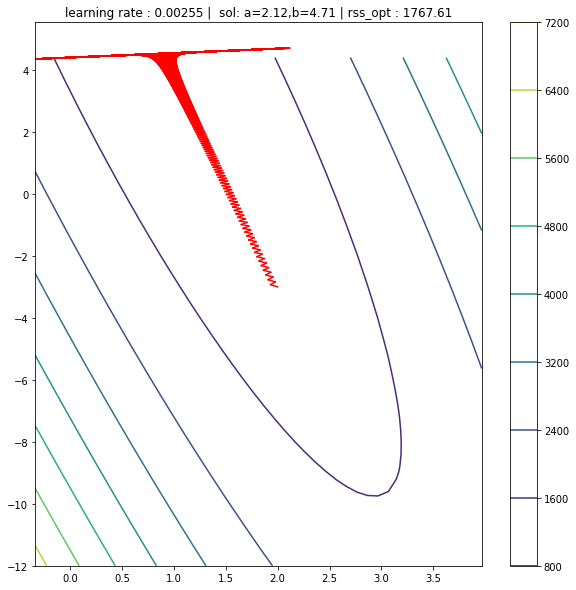

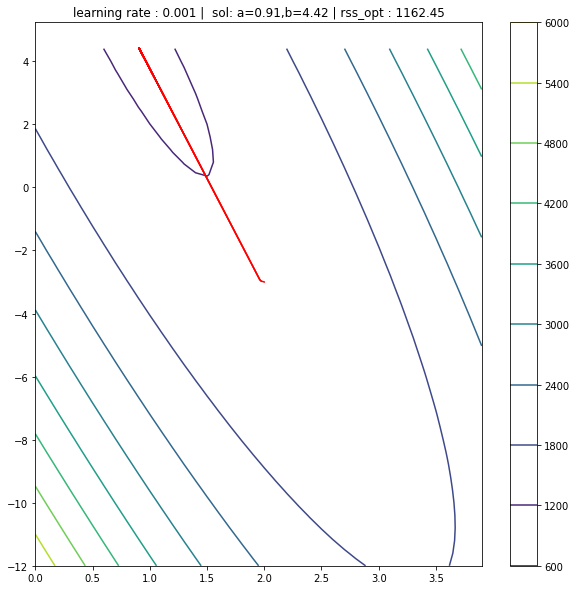

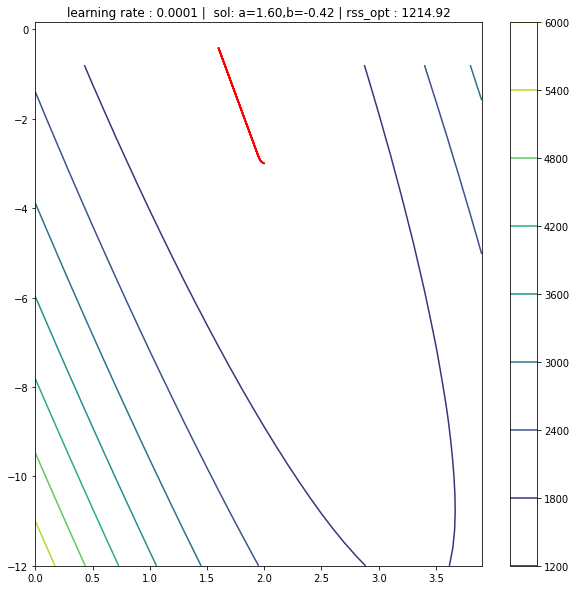

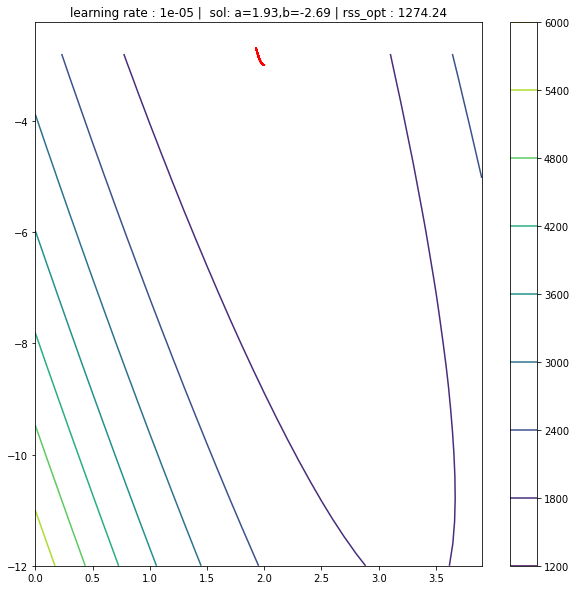

In [469]:
ff = lambda a,b: grad_rss2(a,b,X,Y)
K = 1000

best_rss = np.inf

for learning_eps in [0.00255,1e-3,1e-4,1e-5]:
    _ass,_bss = grad_desc_rss2(K,a0,b0,learning_eps,f,ff,True)
    
    rss_opt = rss_opt = f(_ass[-1],_bss[-1])
    
    if rss_opt < best_rss:
        ass = _ass
        bss = _bss
        best_rss = rss_opt
    
    plt.title("learning rate : {} |  sol: a={:0.2f},b={:0.2f} | rss_opt : {:0.2f}".\
              format(learning_eps,
                    _ass[-1],
                    _bss[-1],
                    rss_opt,
                    ))
    plt.show()


**Q**: *Try different learning rates and interpret the effect. Your answer goes here!*
<br>
<br>
**A**: Similar to what we observed in the one-dimensional case (one variable), setting the learning _too high_ (e.g., 0,0255) makes the gradient based adjustment too large and the error will become increasingly larger rather than smaller; if the learning rate was set to 0.026 here, the error approached infinity and could not even be displayed. Simultaneously, if the step size is too small, we will remain in the flat region but not approach the optimal solution fast enough to reach it within the specified number of iterations.<br>
<br>
Also similar to the case with one parameter, our optimal parameter values do not equate to the true model parameters, explained by the same phenomena of insufficient sampling as for the univarate case.

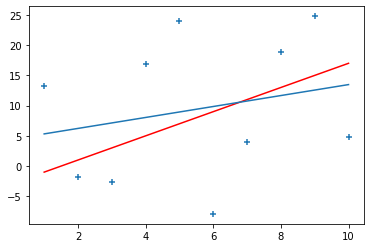

In [470]:
plt.scatter(X,Y,marker = "+")
plt.plot(X,a0*X+b0,color = "red")
plt.plot(X,ass[-1]*X+bss[-1])
plt.show()

## Newton method with two (and more) variables

As in the case for one variable, we observe that $H_{RSS}$ is a constant matrix, i.e., it does not change during the iterations in our quadratic optimization case.

It is still difficult to set the learning rate right. To help this, the Newton method for one variable generalizes:

$$
[a_{k+1}, b_{k+1}] = [a_k,b_k] - H_{RSS}(a_k,b_k)^{-1} \nabla RSS(a_k,b_k) 
$$

where $H_{RSS}$ is the Hessian matrix of $RSS$. 

The Hessian matrix is defined as:
$$
\begin{aligned}
H_{RSS}(a,b) &= 
\begin{bmatrix}
\frac{\partial^2 RSS(a,b)}{\partial a^2} & \frac{\partial^2 RSS(a,b)}{\partial a \partial b} \\
\frac{\partial^2 RSS(a,b)}{\partial b \partial a} & \frac{\partial^2 RSS(a,b)}{\partial b^2} 
\end{bmatrix}\\
&=
\begin{bmatrix}
\frac{\partial (-2\sum_{i=1}^{n}(y_i- a x_i-b)x_i)}{\partial a} & \frac{\partial (-2\sum_{i=1}^{n}(y_i- a x_i-b)x_i)}{\partial b} \\
\frac{\partial (-2\sum_{i=1}^{n}(y_i- a x_i-b)) }{\partial a} & \frac{\partial (-2\sum_{i=1}^{n}(y_i- a x_i-b))}{\partial b} 
\end{bmatrix}\\
&=
\begin{bmatrix}
2\sum_{i=1}^{n}x_i^2 & 2\sum_{i=1}^{n}x_i \\
2\sum_{i=1}^{n}x_i & 2n
\end{bmatrix}\\
&=2
\begin{bmatrix}
\sum_{i=1}^{n}x_i^2 & \sum_{i=1}^{n}x_i \\
\sum_{i=1}^{n}x_i & n
\end{bmatrix}\\
\end{aligned}
$$

In [457]:
H = np.zeros((2,2))
H[0,0] = 2*sum(X**2)
H[0,1] = 2*sum(X)
H[1,0] = H[0,1]
H[1,1] = 2*N
H_inv = np.linalg.inv(H)
print(H)

[[770. 110.]
 [110.  20.]]


Recall the inverse of a $2\times 2$ matrix $H$: 

$$
\begin{aligned}
H^{-1} &=\frac{1}{h_{11}h_{22}-h_{12}h_{21}}
\begin{bmatrix}
h_{22} & -h_{12} \\
-h_{21} & h_{11} 
\end{bmatrix}\\
\end{aligned}
$$

In [458]:
# check that the inverse makes sense
div = H[0,0]*H[1,1] - H[0,1]*H[1,0]
assert np.abs(H_inv[0,0] - H[1,1] /div) < 1e-8
assert np.abs(H_inv[1,0] + H[1,0] /div) < 1e-8
assert np.abs(H_inv[0,1] + H[0,1] /div) < 1e-8
assert np.abs(H_inv[1,1] - H[0,0] /div) < 1e-8

A learning rate $\varepsilon$ only scales the gradient vector; a Hessian matrix scales and rotates the gradient vector. Check how this concrete Hessian matrix transforms (scales and rotates) a unit vector:

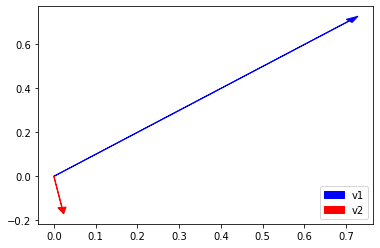

In [459]:
sqr2 = np.sqrt(2)
v = np.array([1/sqr2,1/sqr2])
plt.arrow(0,0, dx = v[0], dy = v[1],shape = "full",head_width = 0.02,label = "v1",color = "blue")
v2 = np.dot(-H_inv,v)
plt.arrow(0,0, dx = v2[0], dy = v2[1],shape = "full",head_width = 0.02,label = "v2",color = "red")
plt.legend()
plt.show()


In [460]:
def newton_rss2(K,a0,b0,H,f,ff,verbose):
    H_inv = np.linalg.inv(H)
    ab = np.zeros((2,K+1))
    ab[0,0] = a0
    ab[1,0] = b0
    for k in range(K):
        grad_w = ff(ab[0,k],ab[1,k])
        ab[:,k+1] = ab[:,k] - np.dot(H_inv,grad_w)
        if verbose:
            plt.plot((ab[0,k],
                      ab[0,k+1]),
                     (ab[1,k],
                     ab[1,k+1],),
                     color = "red",
                    )
    if verbose:
        alow = min([min(ab[0,:]),a0-2])
        ahigh = max([max(ab[0,:]),a0+2])
        blow = min([min(ab[1,:]),b0-9])
        bhigh = max([max(ab[1,:]),b0])
        av = np.arange(alow,ahigh,0.1)
        bv = np.arange(blow,bhigh,0.4)
        A,B = np.meshgrid(av,bv)
        plot3d(f,A,B,real3d=False)
    
    return ab
            
            

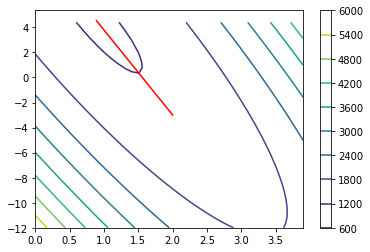

In [461]:
K = 2
ab_newton = newton_rss2(K,a0,b0,H,f,ff,True)

In [462]:
rss_0 = f(a0,b0)
rss_opt = f(ab_newton[0,-1],ab_newton[1,-1])
print("RSS_0 : {:0.2f}".format(rss_0))
print("RSS_opt : {:0.2f}".format(rss_opt))

RSS_0 : 1284.35
RSS_opt : 1162.43


The Newton method could overshoot the minimum (if the loss function is not convex or due to numerical errors). Therefore, the relaxed or damped Newton's method introduces a damping factor $0<\gamma \leq 1$. Also, we exit when we overshoot the optimum.

In [463]:
def damped_newton_rss2(K,a0,b0,H,gamma,f,ff,verbose):
    H_inv = gamma * np.linalg.inv(H)
    
    ab = np.zeros((2,K+1))
    ab[0,0] = a0
    ab[1,0] = b0
    for k in range(K):
        grad_w = ff(ab[0,k],ab[1,k])
        ab[:,k+1] = ab[:,k] - np.dot(H_inv,grad_w)
        
        if f(ab[0,k+1],ab[1,k+1]) >= f(ab[0,k],ab[1,k]):
            k=k-1;
            break
        
        if verbose:
            plt.plot((ab[0,k],
                      ab[0,k+1]),
                     (ab[1,k],
                     ab[1,k+1],),
                     color = "red",
                    )
    res = ab[:,0:k]
    if verbose:
        alow = min([min(ab[0,:]),a0-2])
        ahigh = max([max(ab[0,:]),a0+2])
        blow = min([min(ab[1,:]),b0-9])
        bhigh = max([max(ab[1,:]),b0])
        av = np.arange(alow,ahigh,0.1)
        bv = np.arange(blow,bhigh,0.4)
        A,B = np.meshgrid(av,bv)
        plot3d(f,A,B,real3d=False)
    
    return res

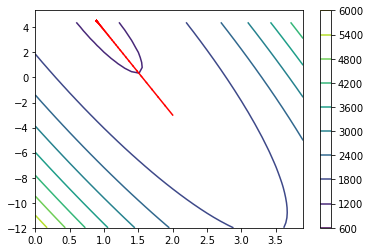

In [464]:
K = 100
gamma = 0.1
ab_newton = damped_newton_rss2(K,a0,b0,H,gamma,f,ff,True)

In [466]:
rss_0 = f(a0,b0)
rss_opt = f(ab_newton[0,-1],ab_newton[1,-1])
print("RSS_0 : {:0.2f}".format(rss_0))
print("RSS_opt : {:0.2f}".format(rss_opt))

RSS_0 : 1284.35
RSS_opt : 1162.43
